# Inverting for fault slip with SlipPy

A simple linear inversion making use of an estimated fault geometry, the Okada model in okapy and our downsampled data in 'okinv' format to try to obtain a best-fitting slip distribution of an earthquake.

## Set it up! 

Let's start with some dependencies:

In [62]:
from okapy import rect_shear_fault
from math import sin, cos, tan, radians, floor
from matplotlib import cm, colors
from scipy.optimize import nnls, Bounds, lsq_linear
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

## Defining the data, model parameters and elastic constants

Load in the downsampled interferogram data:

In [104]:
data = np.loadtxt('./elazig_asc.okinv', delimiter=' ') # or wherever the file is on your system!
data[:,0]*=1000  # convert x coord from km to m
data[:,1]*=1000  # convert y coord from km to m
n_data=np.size(data[:,0])

We need to start with a fault geometry that fits the data, like the best-fitting model from last time. Since we will want to expand the fault dimensions

In [105]:
# this is the best model from before
best_fparams=[5.89834855e+01,  9.84531911e+01, -1.52550469e+01,  7.32238319e-01,
        4.99241223e+05,  4.23994529e+06,  2.89999974e+04,  2.79875955e+03,
        1.68497202e+04]
best_penalty=0.10903328710683108

# extract the details that relate to a finite fault model
print("fault length: {0:5.2f} km, fault width: {1:5.2f}".format(best_fparams[6]/1000,
                                                                best_fparams[8]/sin(radians(best_fparams[1]))/1000))

fault length: 29.00 km, fault width: 17.03


In [126]:
# choose a fault element size (in m)
element_size=3000

# choose expanded fault dimensions (also in m, make them a multiple of the element size)
fault_length=54000
fault_width=27000

# calculate some fault parameters
as_values=np.array(range(0,fault_length,element_size))+(element_size/2)-(fault_length/2)
td_values=np.array(range(0,fault_width,element_size))*sin(radians(best_fparams[1]))                 # top depths
bd_values=(np.array(range(0,fault_width,element_size))+element_size)*sin(radians(best_fparams[1]))  # bottom depths

# count the numbers of elements
n_as=np.size(as_values)
n_dd=np.size(td_values)

print("{0:d} along-strike elements, {1:d} down-dip elements, {2:d} total elements".format(n_as,n_dd,n_as*n_dd))

18 along-strike elements, 9 down-dip elements, 162 total elements


In [127]:
td_values

array([    0.        ,  2967.40886719,  5934.81773438,  8902.22660158,
       11869.63546877, 14837.04433596, 17804.45320315, 20771.86207035,
       23739.27093754])

We want to make an array for each fault parameter, containing all of the appropriate values for each element in order (counting down-dip elements first, and then along-strike). 

In [128]:
# making arrays of the input parameters of our model requires several steps!

# first, make grids of down-dip and along-strike fault element positions
TD, AS = np.meshgrid(td_values,as_values)
BD, AS = np.meshgrid(bd_values,as_values)

# while we're at it, make a proximity 'spatial model' of the positions of our fault elements
SM_proximity=np.array(range(0,n_as*n_dd)).reshape(n_as,n_dd).T
# and make an affinity 'spatial model' of the connectivity of our fault elements
SM_affinity=np.ones(n_as*n_dd).reshape(n_as,n_dd).T  # all ones, because all of our elements are connected

# now make the arrays! some are easy...
strike=np.ones(n_as*n_dd)*best_fparams[0]    # same strike for all elements
dip=np.ones(n_as*n_dd)*best_fparams[1]       # same dip for all elements
rake=np.ones(n_as*n_dd)*best_fparams[2]      # same rake for all elements
slip=np.ones(n_as*n_dd)                      # 1 m of slip for all elements (for the purposes of Green's function calculations) 
as_length=np.ones(n_as*n_dd)*element_size    # use the fault element size we defined above

# ...some are based on our meshgrids
xs=sin(radians(best_fparams[0]))*AS.reshape(-1)+best_fparams[4]   # coordinates of up-dip surface projection
ys=cos(radians(best_fparams[0]))*AS.reshape(-1)+best_fparams[5]   # of the center of each fault element
top_depth=TD.reshape(-1)                     # unravel our top depth meshgrid
bottom_depth=BD.reshape(-1)                  # unravel our top depth meshgrid

Finally, let's define some elastic parameters, using some standard values:

In [130]:
eparams = np.array([30e9, 30e9])  # 1st and 2nd Lame elastic parameters; try 30 GPa for both

## Calculating Green's functions for the slip inversion

We now have all the components we need to calculate the necessary Green's functions for the design matrix of our inverse problem. 

This requires looping through each of the elements in turn. In each step in the loop, we grab the parameters for the corresponding element, run an Okada calculation at our data locations and project the resulting 3D displacements into line-of-sight using okapy, and save the output as a column of a 2D array (the design matrix, <b>A</b>). It's actually surprisingly simple:

In [131]:
# OK, get cracking with the design matrix computation

# make a place to put it
A=np.zeros([n_data, n_as*n_dd])

# loop through yer elements
for i in range(n_as*n_dd):
    fparams = np.array([strike[i], dip[i], rake[i], slip[i], xs[i], ys[i], as_length[i], top_depth[i], bottom_depth[i]])
    model_los_disps = rect_shear_fault(fparams, eparams, data)   # okapy does the heavy lifting
    A[:,i]=model_los_disps

## Assembling a smoothing matrix (a.k.a. regularizing the inversion)

Although we have taken steps to downsample the data in our interferogram, it is likely still the case that our resulting data points are not fully independent, and our inverse problem is not <i>well posed</i> (i.e. has exactly as many independent data as we have unknown model parameters). Indeed, it is quite likely that our problem is <i>underdetermined</i>, with fewer independent data than we have unknowns. The situation where we have more data points than model parameters, but those data points effectively contain less independent information than the number of model parameters, is known as <i>overconstrained and underdetermined</i>, and it is quite a common situation in geophysics!

In [140]:
# # This applies a symmetrical boundary condition

# # ok, let's try this fiddly thing...

# S = np.zeros([n_as*n_dd, n_as*n_dd])

# for i in range(n_as):
    
#     for j in range(n_dd):
        
#         r=SM_proximity[j,i]
#         S[r,r]=-4
                    
#         if j==0:                                  # first row of elements
            
#             r_plus1=SM_proximity[j+1,i]
#             S[r,r_plus1]=2
            
#             if i==0:                              # first column of elements
#                 c_plus1=SM_proximity[j,i+1]
#                 S[r,c_plus1]=2
#             elif i==(n_as-1):                     # last column of elements
#                 c_minus1=SM_proximity[j,i-1]
#                 S[r,c_minus1]=2
#             else:
#                 c_plus1=SM_proximity[j,i+1]
#                 S[r,c_plus1]=1
#                 c_minus1=SM_proximity[j,i-1]
#                 S[r,c_minus1]=1
                
#         elif j==(n_dd-1):                         # last row of elements
            
#             r_minus1=SM_proximity[j-1,i]
#             S[r,r_minus1]=2
            
#             if i==0:                              # first column of elements
#                 c_plus1=SM_proximity[j,i+1]
#                 S[r,c_plus1]=2
#             elif i==(n_as-1):                     # last column of elements
#                 c_minus1=SM_proximity[j,i-1]
#                 S[r,c_minus1]=2
#             else:                                 # not the first or last column of elements
#                 c_plus1=SM_proximity[j,i+1]
#                 S[r,c_plus1]=1
#                 c_minus1=SM_proximity[j,i-1]
#                 S[r,c_minus1]=1
            
#         else:                                     # not the first or last row of elements

#             r_minus1=SM_proximity[j-1,i]
#             S[r,r_minus1]=1
#             r_plus1=SM_proximity[j+1,i]
#             S[r,r_plus1]=1
            
#             if i==0:                              # first column of elements
#                 c_plus1=SM_proximity[j,i+1]
#                 S[r,c_plus1]=2
#             elif i==(n_as-1):                     # last column of elements
#                 c_minus1=SM_proximity[j,i-1]
#                 S[r,c_minus1]=2
#             else:                                 # not the first or last column of elements
#                 c_plus1=SM_proximity[j,i+1]
#                 S[r,c_plus1]=1
#                 c_minus1=SM_proximity[j,i-1]
#                 S[r,c_minus1]=1


In [134]:
# This applies a zero boundary condition

# ok, let's try this fiddly thing...

S = np.zeros([n_as*n_dd, n_as*n_dd])

for i in range(n_as):
    
    for j in range(n_dd):
        
        r=SM_proximity[j,i]
        S[r,r]=-4
                    
        if j==0:                                  # first row of elements
            
            r_plus1=SM_proximity[j+1,i]
            S[r,r_plus1]=1
            
            if i==0:                              # first column of elements
                c_plus1=SM_proximity[j,i+1]
                S[r,c_plus1]=1
            elif i==(n_as-1):                     # last column of elements
                c_minus1=SM_proximity[j,i-1]
                S[r,c_minus1]=1
            else:
                c_plus1=SM_proximity[j,i+1]
                S[r,c_plus1]=1
                c_minus1=SM_proximity[j,i-1]
                S[r,c_minus1]=1
                
        elif j==(n_dd-1):                         # last row of elements
            
            r_minus1=SM_proximity[j-1,i]
            S[r,r_minus1]=1
            
            if i==0:                              # first column of elements
                c_plus1=SM_proximity[j,i+1]
                S[r,c_plus1]=1
            elif i==(n_as-1):                     # last column of elements
                c_minus1=SM_proximity[j,i-1]
                S[r,c_minus1]=1
            else:                                 # not the first or last column of elements
                c_plus1=SM_proximity[j,i+1]
                S[r,c_plus1]=1
                c_minus1=SM_proximity[j,i-1]
                S[r,c_minus1]=1
            
        else:                                     # not the first or last row of elements

            r_minus1=SM_proximity[j-1,i]
            S[r,r_minus1]=1
            r_plus1=SM_proximity[j+1,i]
            S[r,r_plus1]=1
            
            if i==0:                              # first column of elements
                c_plus1=SM_proximity[j,i+1]
                S[r,c_plus1]=1
            elif i==(n_as-1):                     # last column of elements
                c_minus1=SM_proximity[j,i-1]
                S[r,c_minus1]=1
            else:                                 # not the first or last column of elements
                c_plus1=SM_proximity[j,i+1]
                S[r,c_plus1]=1
                c_minus1=SM_proximity[j,i-1]
                S[r,c_minus1]=1


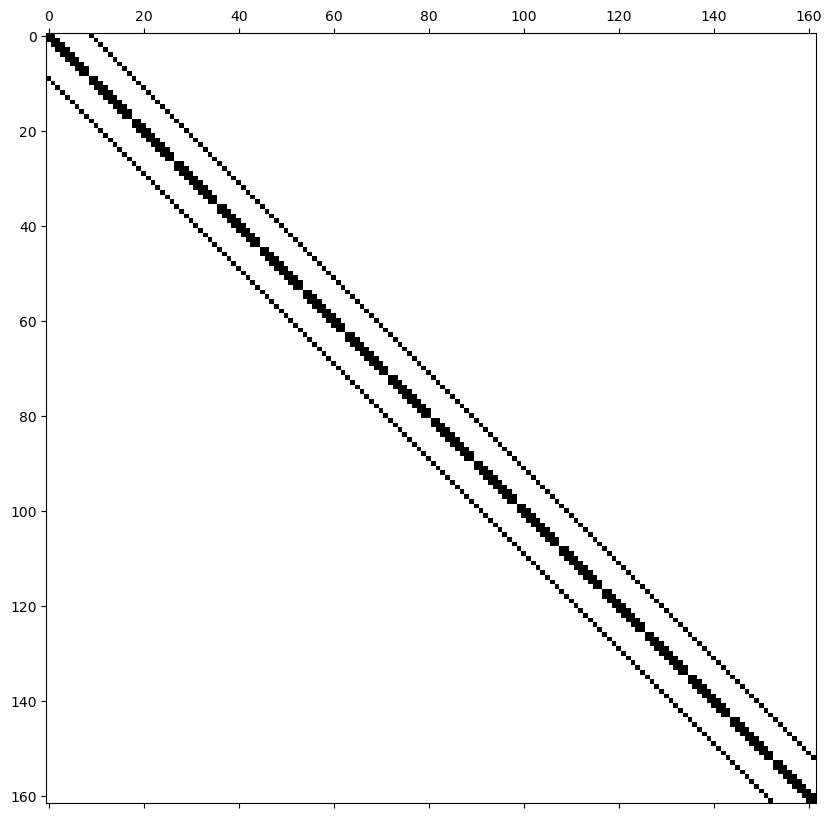

In [135]:
# let's see what we just made! a matlab-style spy plot!
plt.figure(figsize=(10,10))
plt.spy(S)

## Assembling the regularized inverse problem

We now have the major pieces that we need to pose the inverse problem

In [141]:
kappa=0.01    # this is the smoothing parameter
shiftsign=-1  # this is the sign of the nuisance parameter column of '1s'
xgradsign=-1
ygradsign=1

# this concatenates a column of ones to the right of the design matrix:
# np.vstack((A.T,sign*np.ones(n_data))).T

# this concatenates a column of zeros to the right of the smoothing matrix:
# np.vstack((kappa*S.T,np.zeros(n_as*n_dd))).T

# and this concatenates them one above the other
#A_reg=np.vstack((np.vstack((A.T,shiftsign*np.ones(n_data))).T,np.vstack((kappa*S.T,np.zeros(n_as*n_dd))).T))
A_reg=np.vstack((np.vstack((A.T,shiftsign*np.ones(n_data),xgradsign*data[:,0],ygradsign*data[:,1]))
                 .T,np.vstack((kappa*S.T,np.zeros(n_as*n_dd),np.zeros(n_as*n_dd),np.zeros(n_as*n_dd))).T))

# glom a bunch of zeros onto the end of the observed displacements
d_reg=np.hstack((data[:,2],np.zeros(n_as*n_dd)))

# make the normal equations
ATA=np.matmul(A_reg.T,A_reg) 
ATd=np.matmul(A_reg.T,d_reg.T)

# and invert!
#m=np.matmul(np.linalg.inv(ATA),ATd)
m, penalty = nnls(ATA,ATd)                    # if you want to disallow backward slip

# this didn't work
#lowbound=np.concatenate((np.zeros(n_as*n_dd),np.ones(3)*np.inf*(-1)))
#highbound=np.concatenate((np.ones(n_as*n_dd)*np.inf,np.ones(3)*np.inf))
#inv_bounds = Bounds(lowbound,highbound)

#m_results = lsq_linear(ATA,ATd,inv_bounds)
#m = m_results.x

You can see what that looks like in terms of numbers...

In [142]:
m

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.69112687e-02, 1.21638849e-01, 8.70812602e-02, 2.30170568e-02,
       1.70991844e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.52356178e-02, 8.42925937e-02, 5.35576522e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.17118367e-04, 3.76243729e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.96592935e-02,
       5.94128312e-02, 0.00000000e+00, 0.00000000e+00, 6.35011850e-03,
       1.44205577e-02, 4.06357209e-01, 5.71572673e-01, 1.00913070e+00,
       1.19680120e+00, 7.69527046e-01, 2.12590152e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 7.29253652e-01, 1.06289123e+00,
       2.02772840e+00, 2.32934404e+00, 1.47181729e+00, 4.24621207e-01,
       5.17005691e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

Or (preferably) by plotting!

/tmp/ipykernel_831/2136522096.py:46: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb=fig.colorbar(color_map)


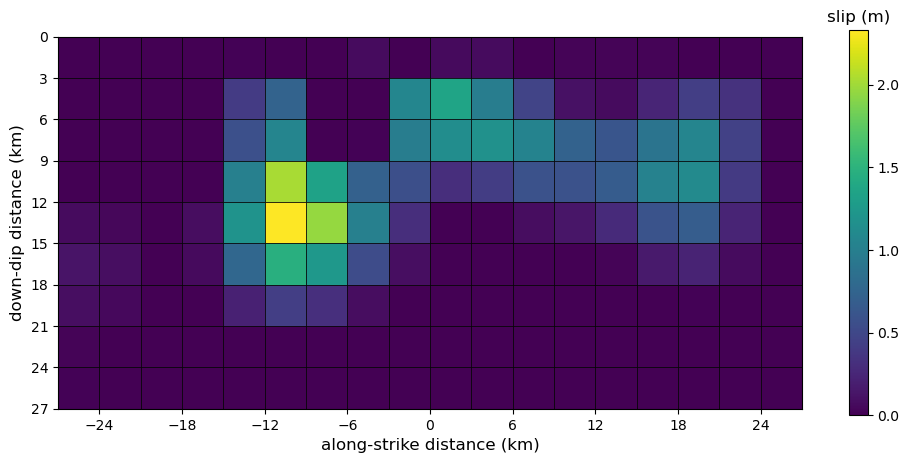

In [143]:
# need to extract vertices for the polygons we'd like to plot

x1=as_values-element_size/2;                                 # -ve end of element along-strike
x2=as_values+element_size/2;                                 # +ve end of element along-strike
y1=np.array(range(0,fault_width,element_size))               # top of element, down-dip
y2=np.array(range(0,fault_width,element_size))+element_size  # bottom of element, down-dip

Y1, X1 = np.meshgrid(y1,x1)
Y2, X2 = np.meshgrid(y2,x2)

# and unravel these meshgrids and bundle the vertices together into a 2D array (also convert to km)
vertices=np.vstack((X1.reshape(-1),Y1.reshape(-1),X2.reshape(-1),Y2.reshape(-1))).T/1000

# the plotting bit

fig, ax = plt.subplots(figsize=[12,5])

ulimit = m.max()
llimit = m.min()

color_map = cm.ScalarMappable(
    norm=colors.Normalize(vmin=llimit, vmax=ulimit))

#for rect, leaf in zip(qt.getMPLRectangles(), qt.leaves):
#    color = color_map.to_rgba(leaf.median)
#    rect.set_facecolor(color)
#    ax3.add_artist(rect)

# loop though the fault elements
for i in range(n_as*n_dd):
    x=np.array(([vertices[i,0],vertices[i,2],vertices[i,2],vertices[i,0]]))
    y=np.array(([vertices[i,1],vertices[i,1],vertices[i,3],vertices[i,3]]))
    color=color_map.to_rgba(m[i])
    ax.fill(x,y,facecolor=color,edgecolor='black',linewidth=0.5)

# some cosmetic things 
ax.set_xlim(vertices[:,0].min(), vertices[:,2].max())
ax.set_ylim(vertices[:,1].min(), vertices[:,3].max())
ax.set_aspect('equal')
ax.invert_yaxis()                                                        # we want +ve down!
ax.set_xlabel("along-strike distance (km)",fontsize=12)
ax.set_ylabel("down-dip distance (km)",fontsize=12)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2*element_size/1000))  # align frame ticks
ax.yaxis.set_major_locator(ticker.MultipleLocator(element_size/1000))    # with elements

cb=fig.colorbar(color_map)
cb.ax.set_title('slip (m)')


plt.show();

## It is good practice to plot your results and residuals

We can use the routines we developed in earlier notebooks to do this!

total squared penalty: 0.066354 m^2
rms penalty: 0.012239 m


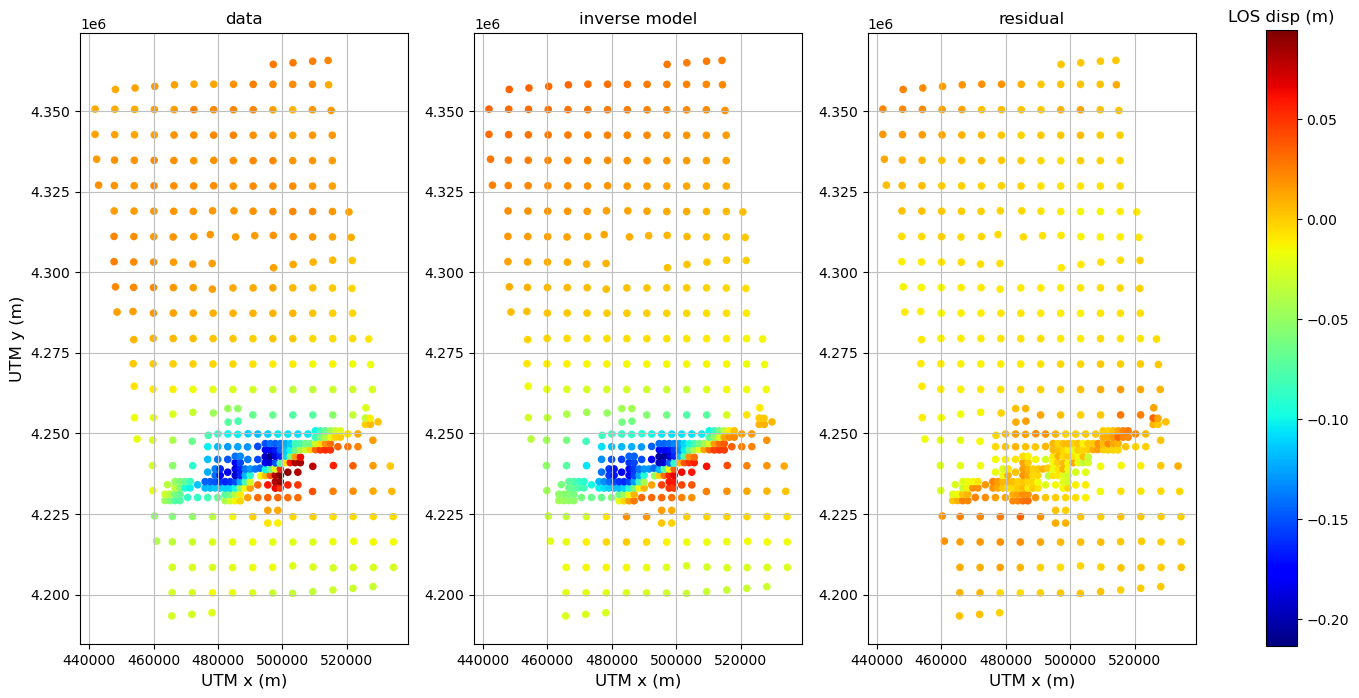

In [144]:
# calculate the displacements
model_los_disps = np.matmul(A_reg[0:n_data,:],m)

# calculate the residuals...
residual_los_disps = model_los_disps-data[:,2]

# and the penalty
los_penalty=np.sum(residual_los_disps**2)
rms_penalty=np.sqrt(los_penalty/n_data)
print("total squared penalty: {0:f} m^2".format(los_penalty))
print("rms penalty: {0:f} m".format(rms_penalty))

# color limits based on the shifted data
cmin, cmax = data[:,2].min(), data[:,2].max()

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(18,8))
axlist = [ax1,ax2,ax3]   # handles for your subplots

# scatter with colormap mapping to z value
scat=ax1.scatter(data[:,0],data[:,1],s=20,c=data[:,2], marker = 'o', cmap = cm.jet, vmin = cmin, vmax = cmax);
ax1.set_xlabel("UTM x (m)",fontsize=12)
ax1.set_ylabel("UTM y (m)",fontsize=12)
ax1.title.set_text('data')
ax1.grid(True,linestyle='-',color='0.75')
ax1.set_aspect('equal')

# scatter with colormap mapping to z value
scat=ax2.scatter(data[:,0],data[:,1],s=20,c=model_los_disps, marker = 'o', cmap = cm.jet, vmin = cmin, vmax = cmax);
ax2.set_xlabel("UTM x (m)",fontsize=12)
ax2.title.set_text('inverse model')
ax2.grid(True,linestyle='-',color='0.75')
ax2.set_aspect('equal')

# scatter with colormap mapping to z value
scat=ax3.scatter(data[:,0],data[:,1],s=20,c=residual_los_disps, marker = 'o', cmap = cm.jet, vmin = cmin, vmax = cmax);
ax3.set_xlabel("UTM x (m)",fontsize=12)
ax3.title.set_text('residual')
ax3.grid(True,linestyle='-',color='0.75')
ax3.set_aspect('equal')

clb=fig.colorbar(scat,ax=axlist)
clb.ax.set_title('LOS disp (m)')

plt.show();

## Searching for the appropriate smoothing parameter

The smoothing parameter, $\kappa$, controls the influence of the smoothing over the inversion. Higher values of $\kappa$ add a greater weight to the smoothing constraint (compared with the requirement to  fit the data), and will tend towards a smoother slip pattern, and <i>vice-versa</i>. But which value is the 'right' value? Smoother models can be more plausible (suppressing wild fluctuations in slip, for example), but the smoother the model, the less well it will fit the data (which is another measure of the plausibility of a model). Ideally, we would find a smoothing parameter such that the modeled slip pattern is absent wild fluctuations, but also fits the data quite well. 

A common way to identify which values of $\kappa$ satisfy those conditions is to i) use a metric to assess how smooth a given slip model is, and ii) evaluate a series of models with different smoothing parameters. 

The metric we use is 'slip roughness' $-$ the average roughness of the slip pattern. We can use the smoothing matrix, <b>S</b>, to calculate it:

$$\text{roughness} = \text{mean} |{\bf S}{\bf m}| $$

So let's get going with running a set of models with different levels of smoothing...

In [61]:
# some trial values of the smoothing parameter
kappa_list=[1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1]

# make some blank arrays to store output
n_sm=np.size(kappa_list)
pen_list=np.zeros(n_sm)
rgh_list=np.zeros(n_sm)

# loop through your kappa list
for i in range(n_sm):
    kappa=kappa_list[i]    # this is the smoothing parameter
    sign=1                 # this is the sign of the nuisance parameter column of '1s'

    # the design matrix augmented with a nuisance parameter column and the smoothing matrix
    A_reg=np.vstack((np.vstack((A.T,sign*np.ones(n_data))).T,
                     np.vstack((kappa*S.T,np.zeros(n_as*n_dd))).T))

    # glom a bunch of zeros onto the end of the observed displacements
    d_reg=np.hstack((data[:,2],np.zeros(n_as*n_dd)))

    # make the normal equations
    ATA=np.matmul(A_reg.T,A_reg) 
    ATd=np.matmul(A_reg.T,d_reg.T)

    # and invert!
    m=np.matmul(np.linalg.inv(ATA),ATd)
    # m, penalty = nnls(ATA,ATd)                    # if you want to disallow backward slip
    
    model_los_disps = np.matmul(np.vstack((A.T,sign*np.ones(n_data))).T,m)
    pen_list[i]=np.matmul((data[:,2]-model_los_disps),(data[:,2]-model_los_disps).T)    
    rgh_list[i]=np.mean(abs(S*m[:-1]))
    
# see what we got (not in a fancy way)
print("kappa")
print(kappa_list)
print("roughness")
print(rgh_list)
print("penalty")
print(pen_list)

kappa
[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
roughness
[0.69558155 0.173397   0.10910193 0.05030125 0.03425385 0.01777356
 0.01692325 0.01646931 0.01333423]
penalty
[0.12826262 0.13987755 0.14435885 0.1559013  0.16344866 0.18898381
 0.21639607 0.29696275 0.36250314]


We typically choose the smoothing values using an 'L-curve'. Plotting roughness (on the x-axis) against misfit (on the y-axis), we (should) obtain am L-shaped graph, with extremes of high-roughness models that fit the data very well (on the lower right), and low-roughness models that don't fit the data well at all (upper left). Somewhere between these extremes, at the 'elbow' of the graph are models that are not very rough that fit the data pretty well. These are the models whose smoothing parameters we want to use.

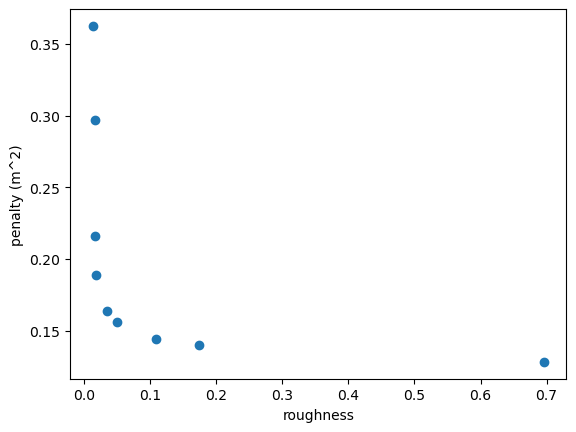

In [27]:
# now plot the L-curve
plt.scatter(rgh_list,pen_list)
plt.gca().set_xlabel("roughness")
plt.gca().set_ylabel("penalty (m^2)")

plt.show()